# Model for predicting flight delays 

This notebook will serve as a single notebook to run all the desired models on a given dataset

## 1. Initial Setup

In [0]:
from pyspark import SparkContext
from pyspark.sql import functions as f
from pyspark.sql.types import StructType, StructField, StringType, DoubleType, IntegerType, NullType, ShortType, DateType, BooleanType, BinaryType
from pyspark.sql import SQLContext, SparkSession

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from pyspark.sql import types
SEED = 7

import warnings
warnings.filterwarnings('ignore')

from IPython.display import Image

In [0]:
# Enable for pretty viewing of tables
spark.conf.set("spark.sql.repl.eagerEval.enabled", True)

In [0]:
username = dbutils.notebook.entry_point.getDbutils().notebook().getContext().tags().apply('user')
userhome = 'dbfs:/user/' + username
print(userhome)
project_path = userhome + "/FinalProject/"
display(dbutils.fs.ls(project_path))

dbfs:/user/chitra.agastya@ischool.berkeley.edu

path,name,size
dbfs:/user/chitra.agastya@ischool.berkeley.edu/FinalProject/Chitra_feature_data/,Chitra_feature_data/,0
dbfs:/user/chitra.agastya@ischool.berkeley.edu/FinalProject/airline_singleday.parquet/,airline_singleday.parquet/,0
dbfs:/user/chitra.agastya@ischool.berkeley.edu/FinalProject/airlines_3m_features_ext.parquet/,airlines_3m_features_ext.parquet/,0
dbfs:/user/chitra.agastya@ischool.berkeley.edu/FinalProject/airlines_3m_full_features.parquet/,airlines_3m_full_features.parquet/,0
dbfs:/user/chitra.agastya@ischool.berkeley.edu/FinalProject/airlines_weather_data/,airlines_weather_data/,0
dbfs:/user/chitra.agastya@ischool.berkeley.edu/FinalProject/airport-timezones.csv,airport-timezones.csv,439779
dbfs:/user/chitra.agastya@ischool.berkeley.edu/FinalProject/airport_edges/,airport_edges/,0
dbfs:/user/chitra.agastya@ischool.berkeley.edu/FinalProject/airport_edges_1_year/,airport_edges_1_year/,0
dbfs:/user/chitra.agastya@ischool.berkeley.edu/FinalProject/airport_edges_3_month/,airport_edges_3_month/,0
dbfs:/user/chitra.agastya@ischool.berkeley.edu/FinalProject/airport_edges_4_year/,airport_edges_4_year/,0


In [0]:
# Load training, validation and test data directories
train_dir = "train.parquet" #"train_transformed_Tuesday_2-59.parquet"
dev_dir = "dev.parquet" #"dev_transformed_Tuesday_2-59.parquet"
test_dir = "test.parquet" #"test_transformed_Tuesday_2-59.parquet"
mode = 'full'
outcome = 'is_delayed'
run = 'full'
loadTransformation = False

save_path = project_path + "Chitra_feature_data"
loadPipelineFromFile = False
savePipeline = False

print(f'Project Path: {project_path} mode:{mode}')

Project Path: dbfs:/user/chitra.agastya@ischool.berkeley.edu/FinalProject/ mode:full

In [0]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler, Imputer, StandardScaler, FeatureHasher, SQLTransformer
from pyspark.ml import Pipeline
from pyspark.ml.classification import DecisionTreeClassifier, RandomForestClassifier, GBTClassifier, LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics

# Load the training data
def loadData(dirName, viewName):
  data = spark.read.option("header", "true").parquet(f'{project_path}{dirName}/*.parquet')
  data.createOrReplaceTempView(viewName)
  return data

def preProcessData(dff, outcome = 'is_delayed'):  
  
  # Take care of unknown weather values
  # Convert pressure 9999 to null
  for col in [x for x in dff.columns if x.endswith('_pressure')]:
    dff = dff.withColumn(col, f.when(f.col(col) == 9999, None).otherwise(f.col(col)))
    
  # Convert ceiling 99999 to None
  for col in [x for x in dff.columns if x.endswith('_ceiling')]:
    dff = dff.withColumn(col, f.when(f.col(col) == 99999, None).otherwise(f.col(col)))
    
  # Convert wind_speed 999.9 to None
  for col in [x for x in dff.columns if x.endswith('_wind_speed')]:
    dff = dff.withColumn(col, f.when(f.col(col) == 999.9, None).otherwise(f.col(col)))
    
  # Convert wind_speed 999.9 to None
  for col in [x for x in dff.columns if x.endswith('_wind_angle')]:
    dff = dff.withColumn(col, f.when(f.col(col) == 999, None).otherwise(f.col(col)))
    
  # Convert visibility and ceiling to integer values
  for col in [x for x in dff.columns if x.endswith('_visibility') or x.endswith('_ceiling')]:
    dff = dff.withColumn(col, dff[col].cast(IntegerType()))

  # Convert temperature and dewpoint to Kelvin by adding 273
  for col in [x for x in dff.columns if x.endswith('_temperature') or x.endswith('_dewpoint')]:
    dff = dff.withColumn(col, dff[col] + 273)
    
  dff = dff.withColumn('time_blk', ((dff['dep_blk'].cast(IntegerType()) + 2) / 8).cast(IntegerType()))
  # cast the equipment_delayed to numeric int
  dff = dff.withColumn('equipment_delayed', dff['equipment_delayed'].cast(IntegerType()))
  
  # create the outcome column
  dff = dff.withColumn(outcome, f.when(f.col('dep_del15') == 1, 1)
                                .otherwise(0)
                      )
  return dff

# a more parallel attempt
def createStages2(dff, outcome, run = 'basic'):
  stages = []
  
  # Get the categorical columns
  categoricalColumnsNoAirports = ['month', 'day_of_month', 'day_of_week', 'op_carrier', 'dep_blk']
  # add equipement_delayed for non-basic runs
  if run != 'basic':
    categoricalColumnsNoAirports += ['equipment_delayed']
  # and our full set includes origin and destination for string indexing 
  filterColumns = ['origin', 'destination'] 
  categoricalColumns = filterColumns + categoricalColumnsNoAirports
  
  
  # index their strings. sadly, no parallel method for that
  stringIndexers = [StringIndexer(inputCol = col, outputCol = col + 'Index').setHandleInvalid("keep") for col in categoricalColumns]
  stages += stringIndexers
          
  # one-hot encode the categorical columns
  encoder = OneHotEncoder(inputCols=[col + 'Index' for col in categoricalColumnsNoAirports], \
                          outputCols=[col + "classVec" for col in categoricalColumnsNoAirports], \
                          handleInvalid='keep')
  stages += [encoder]
  
  # add the outcome label
  label_stringIdx = StringIndexer(inputCol = outcome, outputCol = 'label').setHandleInvalid("keep")
  stages += [label_stringIdx]

  # Get numeric columns
  numericCols = ['distance', 'dest_pagerank', 'src_pagerank', 'weight']
  if run != 'basic':
      numericCols += [x for x in dff.columns if x.startswith('avg_')] + \
      [x for x in dff.columns if (x.startswith('origin_') or x.startswith('destination_'))]
  
  # impute, vectorize and scale numeric columns
  imputedCols = [col+"_Imputed" for col in numericCols]
  imputer = Imputer(inputCols=numericCols, outputCols=imputedCols, strategy='mean')
  
  # from our runs, it looks like the parallel imputer might not have a deterministic output column order
  # make sure the resulting columns are in a defined order
  cols = ['label', 'originIndex', 'destinationIndex'] + [c+"classVec" for c in categoricalColumnsNoAirports] + imputedCols
  col_string = ','.join(cols)
  feature_projector = SQLTransformer(statement=f"SELECT {col_string} FROM __THIS__")
  
  # now convert some of this into a vector and scale its dimensions independently
  assembler = VectorAssembler(inputCols=imputedCols,outputCol="numeric_vect", handleInvalid='keep')
  scaler = StandardScaler(inputCol="numeric_vect", outputCol="numeric_scaled")
  stages += [imputer, feature_projector, assembler, scaler]
  
  # put all the features together
  feature_assembler = VectorAssembler(inputCols=[c + "classVec" for c in categoricalColumnsNoAirports] + ["numeric_scaled"], outputCol="features")
  hash_assembler = VectorAssembler(inputCols=["originIndex", "destinationIndex", "numeric_scaled"], outputCol="hash_vector")
  # final projection of columns, review this carefully
  outputCols = ['label', 'originIndex', 'destinationIndex', 'hash_vector', 'numeric_scaled', 'features'] + [c + "classVec" for c in categoricalColumnsNoAirports]
  col_string = ','.join(outputCols)
  final_projector = SQLTransformer(statement=f"SELECT {col_string} FROM __THIS__")
    
  stages += [feature_assembler, hash_assembler, final_projector]
  
  return stages

# Transform the train, dev and test data with the pipeline
def transformData (d, pl_model, cols):
  return pl_model.transform(d).select(cols)

def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=False):
    """
    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(4, 4))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()
    
def trainModel (type, labelCol, featuresCol, data):
    classifier = None
    model = None
    if type == 'DecisionTree':
        classifier = DecisionTreeClassifier(labelCol= labelCol, featuresCol = featuresCol)
    elif type == 'RandomForest':
        classifier = RandomForestClassifier(featuresCol = featuresCol, labelCol = labelCol, numTrees = 25, maxDepth = 12)
    elif type == 'GBT':
        classifier = GBTClassifier(featuresCol = featuresCol, labelCol = labelCol, maxIter = 20, maxDepth = 8, maxBins = 60) #based on CV grid search 20,8,60 
    elif type == 'Logistic':
        classifier = LogisticRegression(featuresCol = featuresCol, labelCol = labelCol, maxIter= 25, regParam= 0.3, elasticNetParam= 0.8) 
    
    if classifier:
        model = classifier.fit(data)
        
    return model
        
def predictAndEvaluate (data, model, evaluate = True):
    predictions = None
    if model:
        predictions = model.transform(data)
        
    if predictions and evaluate:
        evaluator = BinaryClassificationEvaluator(labelCol="label")
        print("Test Area Under ROC: {}".format(str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"}))))
        print("Test Area Under PR: {}".format(str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderPR"}))))

        evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
        accuracy = evaluator.evaluate(predictions)
        print("Accuracy = %g " % (accuracy))
        print("Test Error = %g " % (1.0 - accuracy))
        
    if predictions:
      evaluateModel(predictions.select('prediction', 'label').rdd.map(tuple), [0,1])

    return predictions

def evaluateModel(predictionAndLabels, labels):
    # Instantiate metrics object
    metrics = MulticlassMetrics(predictionAndLabels)
    
    # Confusion Matrix
    print("Confusion matrix:")
    print(metrics.confusionMatrix().toArray())
    plot_confusion_matrix(metrics.confusionMatrix().toArray(), target_names = ['On-time', 'Delayed'])

    # Overall statistics
    precision = metrics.precision(1.0)
    recall = metrics.recall(1.0)
    f1Score = metrics.fMeasure(1.0)
    print("Summary Stats")
    print("Precision = %s" % precision)
    print("Recall = %s" % recall)
    print("F1 Score = %s" % f1Score)

    # Statistics by class
    for label in sorted(labels):
        print("Class %s precision = %s" % (label, metrics.precision(label)))
        print("Class %s recall = %s" % (label, metrics.recall(label)))
        print("Class %s F1 Measure = %s" % (label, metrics.fMeasure(float(label), beta=1.0)))

    # Weighted stats
    print("Weighted recall = %s" % metrics.weightedRecall)
    print("Weighted precision = %s" % metrics.weightedPrecision)
    print("Weighted F(1) Score = %s" % metrics.weightedFMeasure())
    print("Weighted F(0.5) Score = %s" % metrics.weightedFMeasure(beta=0.5))
    print("Weighted false positive rate = %s" % metrics.weightedFalsePositiveRate)
    
#partition the train_sample into an 80% for train and 20% for validation so that early stopping can be enabled
def createTrainValSplit(dff, ratio =0.8):
    # do a split within training data
    t = dff.sample(fraction = ratio, seed=SEED)
    v = dff.subtract(t)
    
    # add validation column
    t = t.withColumn('validation', f.lit('False').cast(BooleanType()))
    v = v.withColumn('validation', f.lit('True').cast(BooleanType()))
    return t.union(v)
  
#load the ETL data and preprocess before we can train the model
def loadEtlData(valDuringTrain = False):
  train_data = preProcessData(loadData(train_dir, 'train_data')).cache()
  if valDuringTrain:
    train_data = createTrainValSplit(train_data).cache()
  dev_data = preProcessData(loadData(dev_dir, 'dev_data'))
  test_data = preProcessData(loadData(test_dir, 'test_data'))
  return train_data, dev_data, test_data

def ExtractFeatureImp(featureImp, dataset, featuresCol):
    list_extract = []
    
    numericCols = ['distance', 'dest_pagerank', 'src_pagerank', 'weight'] + \
      [x for x in train_data.columns if x.startswith('avg_')] + \
      [x for x in train_data.columns if (x.startswith('origin_') or x.startswith('destination_'))]
    
    for i in dataset.schema["features"].metadata["ml_attr"]["attrs"]:
        list_extract = list_extract + dataset.schema[featuresCol].metadata["ml_attr"]["attrs"][i]
    varlist = pd.DataFrame(list_extract)
    varlist['score'] = varlist['idx'].apply(lambda x: featureImp[x])
    varlist['friendly_name'] = varlist['idx'].apply(lambda x: numericCols[x - 96] if x > 95 else None)
    varlist['friendly_name'] = varlist['friendly_name'].mask(pd.isnull, varlist['name'])
    return(varlist.sort_values('score', ascending = False))

# 2. Data

### 2.1 Load the Data

In [0]:
if loadTransformation:
  print('loading transformation')
  train_data = loadData(train_dir, 'train_data').cache()
  dev_data = loadData(dev_dir, 'dev_data').cache()
  test_data = loadData(test_dir, 'test_data')
else:
  print('loading raw ETL data')
  train_data, dev_data, test_data = loadEtlData()

display(train_data)

loading raw ETL data

origin,destination,year,month,day_of_month,day_of_week,crs_dep_time_utc,naive_crs_arr_time_utc,tail_num,op_carrier,distance,dep_blk,dep_del15,nas_delay,carrier_delay,weather_delay,security_delay,late_aircraft_delay,arr_delay,crs_arr_time_utc,arr_hour_utc,dep_hour_utc,hour,del_tail_num,equipment_delayed,dest_pagerank,src_pagerank,weight,avg_trips_per_day,avg_tp_per_day,avg_flights_per_day,avg_car_per_day,avg_car_flights_per_day,origin_2_wind_angle,origin_2_wind_speed,origin_2_ceiling,origin_2_visibility,origin_2_temperature,origin_2_dewpoint,origin_2_pressure,origin_3_wind_angle,origin_3_wind_speed,origin_3_ceiling,origin_3_visibility,origin_3_temperature,origin_3_dewpoint,origin_3_pressure,origin_4_wind_angle,origin_4_wind_speed,origin_4_ceiling,origin_4_visibility,origin_4_temperature,origin_4_dewpoint,origin_4_pressure,origin_5_wind_angle,origin_5_wind_speed,origin_5_ceiling,origin_5_visibility,origin_5_temperature,origin_5_dewpoint,origin_5_pressure,destination_2_wind_angle,destination_2_wind_speed,destination_2_ceiling,destination_2_visibility,destination_2_temperature,destination_2_dewpoint,destination_2_pressure,destination_3_wind_angle,destination_3_wind_speed,destination_3_ceiling,destination_3_visibility,destination_3_temperature,destination_3_dewpoint,destination_3_pressure,destination_4_wind_angle,destination_4_wind_speed,destination_4_ceiling,destination_4_visibility,destination_4_temperature,destination_4_dewpoint,destination_4_pressure,destination_5_wind_angle,destination_5_wind_speed,destination_5_ceiling,destination_5_visibility,destination_5_temperature,destination_5_dewpoint,destination_5_pressure,time_blk,is_delayed
ABE,ATL,2015,1,30,5,2015-01-30T11:35:00.000+0000,2015-01-30T14:04:00.000+0000,N603AT,DL,692.0,6,0.0,null,null,null,null,null,-11.0,2015-01-30T14:04:00.000+0000,2015-01-30T14:00:00.000+0000,2015-01-30T11:00:00.000+0000,null,null,0,9.031150214803475,0.5947237603125133,0.09090909090909091,1.0,8,2.64,2,1.03,751.75,6.7,792,11265,252.4,248.6,1011.9,20.0,6.2,884,11265,253.0,248.6,1012.2,469.6666666666667,7.7,945,8047,253.0,248.6,1013.0,751.75,5.7,396,9656,253.0,248.6,1013.6,330.0,10.3,732,16093,279.1,272.4,1021.9,335.0,11.8,792,16093,281.3,275.2,1021.1,320.0,9.3,975,16093,283.6,276.9,1020.1,280.0,4.1,1067,16093,285.8,276.3,1019.1,1,0
ABE,ATL,2015,3,31,2,2015-03-31T16:02:00.000+0000,2015-03-31T18:10:00.000+0000,N916EV,EV,692.0,12,0.0,null,null,null,null,null,-18.0,2015-03-31T18:10:00.000+0000,2015-03-31T18:00:00.000+0000,2015-03-31T16:00:00.000+0000,null,null,0,9.031150214803475,0.5947237603125133,0.09090909090909091,1.02,8,2.64,4,1.7,275.0,2.6,2134,16093,260.2,258.6,1005.2,629.5,3.1,22000,16093,259.7,258.6,1005.2,624.5,3.6,22000,16093,260.2,259.1,1004.9,275.0,6.2,22000,16093,261.3,259.7,1004.7,250.0,3.1,488,16093,274.0,273.0,1003.2,474.75,1.5,427,16093,274.0,273.0,1003.1,220.0,1.5,22000,16093,282.4,277.4,1018.3,230.0,1.5,22000,16093,281.9,277.4,1017.8,1,0
ABE,ATL,2015,4,24,5,2015-04-24T10:40:00.000+0000,2015-04-24T12:47:00.000+0000,N906AT,DL,692.0,6,0.0,null,null,null,null,null,4.0,2015-04-24T12:47:00.000+0000,2015-04-24T12:00:00.000+0000,2015-04-24T10:00:00.000+0000,null,null,0,9.031150214803475,0.5947237603125133,0.09090909090909091,1.0,8,2.64,2,1.03,195.0,7.2,1280,16093,275.2,266.3,1000.9,155.0,5.1,884,11265,275.8,266.9,1000.9,210.0,6.2,1189,16093,276.3,266.3,1001.0,200.0,4.1,1311,16093,276.9,266.3,1000.8,320.0,3.6,22000,16093,284.1,274.7,1016.0,320.0,4.1,22000,16093,285.2,274.7,1015.8,320.0,4.1,22000,16093,285.8,276.3,1016.0,320.0,4.1,22000,16093,286.3,278.0,1016.2,1,0
ABE,ATL,2015,5,7,4,2015-05-07T16:02:00.000+0000,2015-05-07T18:08:00.000+0000,N884AS,EV,692.0,12,0.0,null,null,null,null,null,-5.0,2015-05-07T18:08:00.000+0000,2015-05-07T18:00:00.000+0000,2015-05-07T16:00:00.000+0000,null,null,0,9.031150214803475,0.5947237603125133,0.09090909090909091,1.0,8,2.64,4,1.7,614.5,1.5,1524,16093,279.1,276.3,1006.8,579.5,1.5,1402,16093,277.4,275.8,1007.4,559.5,3.1,1402,16093,278.0,276.3,1007.6,95.0,2.6,1341,1

In [0]:
train_data.count()

Out[7]: 20716594

In [0]:
train_data.groupBy(outcome).count().show()

+----------+--------+
is_delayed| count|
+----------+--------+
 1| 3077525|
 0|17639069|
+----------+--------+

In [0]:
train_data.where('origin_2_pressure == 9999').count()

Out[11]: 0

# 3. Create and Run Pipeline

Test Area Under ROC: 0.6696694449763777
Test Area Under PR: 0.28591664405865047
Accuracy = 0.852732 
Test Error = 0.147268 
Confusion matrix:
[[1946705. 3515.]
 [ 334270. 9182.]]

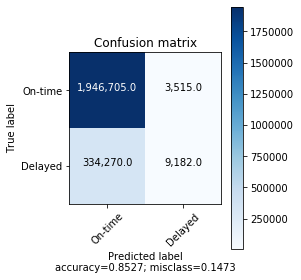

Summary Stats
Precision = 0.7231629518783965
Recall = 0.026734449064206935
F1 Score = 0.05156268864997515
Class 0 precision = 0.8534530189940706
Class 0 recall = 0.998197639240701
Class 0 F1 Measure = 0.9201679430988172
Class 1 precision = 0.7231629518783965
Class 1 recall = 0.026734449064206935
Class 1 F1 Measure = 0.05156268864997515
Weighted recall = 0.8527317768190047
Weighted precision = 0.8339435232461988
Weighted F(1) Score = 0.7901039183163009
Weighted F(0.5) Score = 0.7647687609992929
Weighted false positive rate = 0.8277996885140967

In [0]:
from pyspark.ml import Pipeline, PipelineModel

gbt = GBTClassifier(stepSize = 0.064, maxIter = 14, maxDepth = 4, maxBins = 27)
model = None

# E2E Pipeline
if loadTransformation:
  model = gbt.fit(train_data)
else:
  stages = createStages2(train_data, outcome, run)
  stages += [gbt]
  pipeline = Pipeline(stages = stages)
  #Transform and train the model
  model = pipeline.fit(train_data)

# Evaluate model 
predictions = predictAndEvaluate(dev_data, model)

In [0]:
tree = model.stages[-1]
train = model.transform(train_data)

features = ExtractFeatureImp(tree.featureImportances, train, "features").head(20)
display(features)

idx,name,score,friendly_name
74,dep_blkclassVec_7,0.10368365995478933,dep_blkclassVec_7
54,op_carrierclassVec_DL,0.0715370915744097,op_carrierclassVec_DL
141,numeric_scaled_45,0.06105636242573996,destination_3_wind_speed
151,numeric_scaled_55,0.04976227245547619,destination_4_temperature
108,numeric_scaled_12,0.04548662755431281,origin_2_visibility
156,numeric_scaled_60,0.04478532472905381,destination_5_ceiling
106,numeric_scaled_10,0.04099887145806065,origin_2_wind_speed
75,dep_blkclassVec_8,0.038651121696458964,dep_blkclassVec_8
113,numeric_scaled_17,0.03840214436292115,origin_3_wind_speed
134,numeric_scaled_38,0.038048179759815545,destination_2_wind_speed


Test Area Under ROC: 0.6602414619808712
Test Area Under PR: 0.277120110962438
Accuracy = 0.847356 
Test Error = 0.152644 
Confusion matrix:
[[5769870. 10906.]
 [1033386. 27190.]]

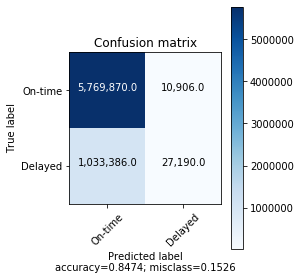

Summary Stats
Precision = 0.7137232255354893
Recall = 0.02563701234046405
F1 Score = 0.04949611895087888
Class 0 precision = 0.8481042018703985
Class 0 recall = 0.9981134020761226
Class 0 F1 Measure = 0.9170145149026957
Class 1 precision = 0.7137232255354893
Class 1 recall = 0.02563701234046405
Class 1 F1 Measure = 0.04949611895087888
Weighted recall = 0.847355902751386
Weighted precision = 0.8272718812476074
Weighted F(1) Score = 0.7825280580875816
Weighted F(0.5) Score = 0.7562110587526332
Weighted false positive rate = 0.8236054883347994

In [0]:
#Evaluate model for test dev_data
predictions = predictAndEvaluate(test_data, model)